In [1]:
'''Helper'''
import pandas as pd
import numpy as np
import time
import joblib
import pickle
import re
import string
import unicodedata
import matplotlib.pyplot as plt
from numpy import argmax
import scipy
# import spacy
from sklearn.metrics.pairwise import cosine_similarity

'''Models'''
from transformers import pipeline
# from onnx_transformers import pipeline # to run this -- downgrade transformers library to 3.2.0

'''Display'''
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.1f' % x)

In [2]:
!pip show transformers

Name: transformers
Version: 4.10.3
Summary: State-of-the-art Natural Language Processing for TensorFlow 2.0 and PyTorch
Home-page: https://github.com/huggingface/transformers
Author: Thomas Wolf, Lysandre Debut, Victor Sanh, Julien Chaumond, Sam Shleifer, Patrick von Platen, Sylvain Gugger, Suraj Patil, Stas Bekman, Google AI Language Team Authors, Open AI team Authors, Facebook AI Authors, Carnegie Mellon University Authors
Author-email: thomas@huggingface.co
License: Apache
Location: /opt/conda/lib/python3.7/site-packages
Requires: numpy, sacremoses, tokenizers, importlib-metadata, pyyaml, huggingface-hub, regex, filelock, tqdm, requests, packaging
Required-by: sentence-transformers


* onnx, parallel, small model

### Input data

In [3]:
df = pd.read_pickle("./data/preprocess_mnet_train.pkl")

df.drop_duplicates('natid', keep='first', inplace=True)
df.reset_index(drop=True, inplace=True)

print(df.shape)
df.head()

(10078, 8)


,natid,pub_date,category,tier1,tier2,summary,clean_summary,label
0,blogandpostid/blog/post/50808-607eda2d97a5b000...,2021-04-20,Personal Finance,Real Estate,Real Estate Renting and Leasing,WeWork To Accept Crypto—And Will Pay Its Landl...,wework accept crypto pay landlords crypto. top...,7
1,blogandpostid/blog/post/4587-60d354bc9690ca000...,2021-06-23,Food and Drink,Travel,Travel Type,Celebrate The Lodge At Woodloch’s 15-Year Anni...,celebrate lodge woodloch's 15-year anniversary...,23
2,blogandpostid/blog/post/3113-5f526f97559f59000...,2020-09-04,Music and Audio,Music and Audio,Hip Hop Music,Cardi B And Megan Thee Stallion Both Earn Thei...,cardi b megan thee stallion earn no. 1 hit you...,12
3,blogandpostid/blog/post/5259-6015f002c7824f000...,2021-02-09,Travel,Shopping,Gifts and Greetings Cards,Valentine’s Day Gift Guide: The Most Romantic ...,valentine's day gift guide: romantic hotel pac...,13
4,blogandpostid/blog/post/4983-5f8064d69a4142000...,2020-10-14,Shopping,Shopping,Sales and Promotions,The Best Prime Day Bike Deals For Saving Big o...,best prime day bike deals saving big bicycles ...,13


count    10078
mean      3592
std       2133
min        433
25%       2227
50%       3149
75%       4326
max      30344
Name: clean_summary, dtype: int64

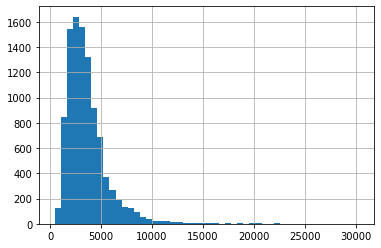

In [4]:
df.clean_summary.str.len().hist(bins=50)
df.clean_summary.str.len().describe().apply(int)

In [5]:
candidate_labels = df.tier1.unique().tolist()

print("Tier 1 labels: ", len(candidate_labels))
print("Tier 2 labels: ", len(df.tier2.unique()))

Tier 1 labels:  28
Tier 2 labels:  284


In [6]:
df.tier1.value_counts()

Business and Finance        445
Personal Finance            442
News and Politics           442
Technology & Computing      440
Sports                      438
Medical Health              436
Video Gaming                422
Travel                      414
Science                     406
Automotive                  404
Style & Fashion             403
Events and Attractions      402
Careers                     398
Shopping                    395
Food & Drink                392
Music and Audio             388
Real Estate                 381
Education                   376
Movies                      369
Television                  343
Healthy Living              339
Home & Garden               328
Hobbies & Interests         314
Family and Relationships    302
Fine Art                    226
Pets                        152
Books and Literature        148
Pop Culture                 133
Name: tier1, dtype: int64

### Experiments

In [7]:
# model = 'valhalla/distilbart-mnli-12-3' # gave bad results
model = 'joeddav/bart-large-mnli-yahoo-answers'

classifier = pipeline("zero-shot-classification", 
                      model = model, 
                      framework="pt") #, device=0

* Trying 1 - with transformers pipeline
    * checked - 
        * cleaning differently not making any difference
        * not using hypothesis statement not making any difference

In [8]:
test_1 = df.clean_summary[0]

print("Seq len: ", len(test_1), "\n")
start_time = time.time()

res = classifier(test_1, candidate_labels, multi_label=True)
print(res, "\n")
print(res['labels'][0], res['labels'][1], res['labels'][2])
print(res['scores'][0], res['scores'][1], res['scores'][2])

print("time (mins) - ", round((time.time() - start_time)/60, 2))

Seq len:  1549 

{'sequence': "wework accept crypto pay landlords crypto. topline wework start accepting payment cryptocurrencies intends hold assets balance sheet, office sharing giant announced tuesday, similar elon musk's tesla march said retain bitcoin purchase cars signal confidence cryptocurrencies inch mainstream acceptance. key facts wework said accept bitcoin, ethereum, usd coin, paxos cryptocurrencies payment offerings, including memberships. company said retain payments balance sheet converting currency look pay landlords partners crypto amenable. coinbase, usa' largest crypto exchange went public l ast week, client pay wework membership cryptocurrency, statement said. wework chief executive sandeep mathrani, said company needs adapt needs growing membership fintech sector service new economy. key background cryptocurrencies increasingly popular form payment. elon musk's tesla, holds sizable investment currency, attracted headlines announced accept bitcoin payment cars. venm

In [8]:
test_1 = df.clean_summary[0]

print("Seq len: ", len(test_1), "\n")
start_time = time.time()

candidate_labels_t2 = df.tier2.unique().tolist()
print(len(candidate_labels_t2))

res = classifier(test_1, candidate_labels_t2, multi_label=True)
# print(res, "\n")
print(res['labels'][0], res['labels'][1], res['labels'][2])
print(res['scores'][0], res['scores'][1], res['scores'][2])

print("time (mins) - ", round((time.time() - start_time)/60, 2))

Seq len:  1549 

284
Business Economy Industries
0.8300521373748779 0.6493587493896484 0.6401695609092712
time (mins) -  0.51


* Trying 10 (feeding 1-by-1 via looping) - transfomers pipeline

In [35]:
# TIER 2

prim_labels = []
sec_labels = []
ter_labels = []

prim_scores = []
sec_scores = []
ter_scores = []

start_time = time.time()

for i in range(len(df.clean_summary[:10].tolist())):

    res = classifier(df.clean_summary[i][:4000], candidate_labels_t2, multi_label=True)
    
    prim_labels.append(res['labels'][0])
    sec_labels.append(res['labels'][1])
    ter_labels.append(res['labels'][2])
    
    prim_scores.append(res['scores'][0])
    sec_scores.append(res['scores'][1])
    ter_scores.append(res['scores'][2])

print("time (mins) - ", round((time.time() - start_time)/60, 2), "\n")

test2 = pd.DataFrame(df.clean_summary[:10])
test2["prim_labels"] = prim_labels
test2["sec_labels"] = sec_labels
test2["ter_labels"] = ter_labels

test2["prim_scores"] = prim_scores
test2["sec_scores"] = sec_scores
test2["ter_scores"] = ter_scores 

time (mins) -  9.09 



In [33]:
# TIER 1
match = []
for i in range(len(df['tier1'][:10])):
    if df['tier1'][:10][i] in (test['prim_labels'] + " " + test['sec_labels'] + " " + test['ter_labels'])[i]:
        match.append(True)
        
print((len(match)/10)*100)

test

60.0


,clean_summary,prim_labels,sec_labels,ter_labels,prim_scores,sec_scores,ter_scores
0,wework accept crypto pay landlords crypto. top...,Business and Finance,Technology & Computing,Personal Finance,0.9,0.5,0.4
1,celebrate lodge woodloch's 15-year anniversary...,Healthy Living,Medical Health,Events and Attractions,1.0,0.9,0.5
2,cardi b megan thee stallion earn no. 1 hit you...,Music and Audio,Pop Culture,Business and Finance,1.0,0.9,0.8
3,valentine's day gift guide: romantic hotel pac...,Pop Culture,Events and Attractions,Shopping,0.9,0.6,0.6
4,best prime day bike deals saving big bicycles ...,Shopping,Automotive,Personal Finance,1.0,0.9,0.9
5,"weber takes grilling innovative new heights, p...",Business and Finance,Food & Drink,Personal Finance,1.0,0.6,0.6
6,korean superstars twice history billboard 200 ...,Pop Culture,Music and Audio,Careers,1.0,1.0,0.7
7,"pick mehve glider toy nausica '. remember, cov...",Hobbies & Interests,Business and Finance,Pop Culture,0.9,0.9,0.9
8,best jewelry wear halloween. halloween certain...,Pop Culture,Style & Fashion,Events and Attractions,1.0,0.9,0.7
9,comvita honey company wants buzz world bee day...,Business and Finance,Food & Drink,Hobbies & Interests,0.9,0.8,0.7


In [38]:
# TIER 2

match = []
for i in range(len(df['tier2'][:10])):
    if df['tier2'][:10][i] in (test2['prim_labels'] + " " + test2['sec_labels'] + " " + test2['ter_labels'])[i]:
        match.append(True)
        
print((len(match)/10)*100)

test2

30.0


,clean_summary,prim_labels,sec_labels,ter_labels,prim_scores,sec_scores,ter_scores
0,wework accept crypto pay landlords crypto. top...,Business,Economy,Industries,0.8,0.6,0.6
1,celebrate lodge woodloch's 15-year anniversary...,Wellness,Personal Care,Beauty,1.0,0.9,0.8
2,cardi b megan thee stallion earn no. 1 hit you...,Hip Hop Music,Urban Contemporary Music,Adult Contemporary Music,1.0,0.9,0.9
3,valentine's day gift guide: romantic hotel pac...,National & Civic Holidays,Party Supplies and Decorations,Bereavement,0.9,0.9,0.9
4,best prime day bike deals saving big bicycles ...,Coupons and Discounts,Auto Buying and Selling,Consumer Electronics,1.0,0.9,0.9
5,"weber takes grilling innovative new heights, p...",Business,Industries,Economy,1.0,1.0,0.9
6,korean superstars twice history billboard 200 ...,National & Civic Holidays,International Music,Sales and Promotions,0.9,0.9,0.8
7,"pick mehve glider toy nausica '. remember, cov...",Animation Movies,Children's Games and Toys,Consumer Electronics,0.9,0.9,0.9
8,best jewelry wear halloween. halloween certain...,Holiday Shopping,Costume,National & Civic Holidays,1.0,1.0,1.0
9,comvita honey company wants buzz world bee day...,Beekeeping,Industries,Business,0.9,0.9,0.9


* Trying joblib multi-processing

In [9]:
def get_class(article):
    model = 'joeddav/bart-large-mnli-yahoo-answers'

    classifier = pipeline("zero-shot-classification", 
                      model = model, 
                      framework="pt") #, device=0

    return classifier(article, candidate_labels, multi_label=True)

In [39]:
from joblib import Parallel, delayed

df_proc = df.clean_summary[:100][:10].to_list()

# Parallel processing

start = time.time()

res_output = Parallel(n_jobs=-1)(delayed(get_class)(article_body) for article_body in df_proc)

print("article_embeddings len:", len(res_output))
print()
print('time {} minutes'.format(round((time.time() - start) / 60, 2))) #3.22

IndexError: index out of range in self

* Trying 10 (feeding 1-by-1 via looping) - onnx pipeline
    * **verdict:** horrible results and run-time

In [14]:
from onnx_transformers import pipeline

# default model is roberta-large-mnli
onnx_classifier = pipeline("zero-shot-classification", onnx=True) 

ModuleNotFoundError: No module named 'transformers.configuration_auto'

In [8]:
# trying 1 - with transformers pipeline

print("Seq len: ", len(test_1), "\n")
start_time = time.time()

res = onnx_classifier(test_1, candidate_labels, multi_class=True)
print(res, "\n")
print(res['labels'][0], res['labels'][1], res['labels'][2])
print(res['scores'][0], res['scores'][1], res['scores'][2])

print("time (mins) - ", round((time.time() - start_time)/60, 2))

Seq len:  1549 

{'sequence': "wework accept crypto pay landlords crypto. topline wework start accepting payment cryptocurrencies intends hold assets balance sheet, office sharing giant announced tuesday, similar elon musk's tesla march said retain bitcoin purchase cars signal confidence cryptocurrencies inch mainstream acceptance. key facts wework said accept bitcoin, ethereum, usd coin, paxos cryptocurrencies payment offerings, including memberships. company said retain payments balance sheet converting currency look pay landlords partners crypto amenable. coinbase, usa' largest crypto exchange went public l ast week, client pay wework membership cryptocurrency, statement said. wework chief executive sandeep mathrani, said company needs adapt needs growing membership fintech sector service new economy. key background cryptocurrencies increasingly popular form payment. elon musk's tesla, holds sizable investment currency, attracted headlines announced accept bitcoin payment cars. venm

### Create dataset

In [7]:
model = 'joeddav/bart-large-mnli-yahoo-answers'

classifier = pipeline("zero-shot-classification", 
                      model = model, 
                      framework="pt") #, device=0

candidate_labels = df.tier1.unique().tolist()
print(len(candidate_labels))

28


In [8]:
prim_labels = []
sec_labels = []
ter_labels = []

prim_prob = []
sec_prob = []
ter_prob = []

begin = 200 # 100 #0
end = 500 # 200 #100
df[begin:end]

,natid,pub_date,category,tier1,tier2,summary,clean_summary,label
200,blogandpostid/blog/post/1439-5f621d59249a6f000...,2020-09-16,Style and Fashion,Style & Fashion,Women's Fashion,Newest Bond Girl Becomes First Brand Ambassado...,newest bond girl brand ambassador diamond indu...,17
201,blogandpostid/blog/post/7152-5fc7073f340d6d000...,2020-12-01,News and Politics,Events and Attractions,Awards Shows,Oscar Nominee Elliot Page Comes Out As Transge...,oscar nominee elliot page comes transgender. t...,5
202,blogandpostid/blog/post/50404-5fac0d85d5fbc700...,2020-11-27,Travel,Shopping,Gifts and Greetings Cards,Holiday Gift Guide 2020: 9 Top Hotel Souvenirs...,holiday gift guide 2020: 9 hotel souvenirs rel...,13
203,blogandpostid/blog/post/7109-5f553ed3480c1a000...,2020-09-06,Sports,Sports,American Football,The Kansas City Chiefs Make Good Use Of New Pr...,kansas city chiefs good use new practice squad...,18
204,blogandpostid/blog/post/25-5f7aa84b00e76800067...,2020-10-05,Personal Finance,Personal Finance,Personal Investing,Riskier Gaming Stock: MGM Resorts Or Scientifi...,riskier gaming stock: mgm resorts scientific g...,21
...,...,...,...,...,...,...,...,...
495,blogandpostid/blog/post/4972-60105ac02ee113000...,2021-01-27,Real Estate,Real Estate,Developmental Sites,How Commercial Property Owners Can Cut Through...,commercial property owners cut hype cre tech. ...,7
496,blogandpostid/blog/post/50564-5f47b422b0b20600...,2020-08-27,News and Politics,News and Politics,Disasters,"Hurricane Laura Downgraded To Category 2, But ...","hurricane laura downgraded category 2, life-th...",0
497,blogandpostid/blog/post/1174-6010527f4c0893000...,2021-01-26,Video Gaming,Video Gaming,Video Game Genres,"‘Destiny 2’ Reset Update: Crow Not Speaker, Do...","destiny 2' reset update: crow speaker, double ...",10
498,blogandpostid/blog/post/2092-5fee774dfa09d7000...,2020-12-31,Science,Science,Space and Astronomy,NASA’s First Mars Flyby Set The Stage For Toda...,nasa's mars flyby set stage today's rovers. we...,1


In [9]:
start_time = time.time()

art_list = df.clean_summary[begin:end].tolist()
print(len(art_list))

for i in range(len(art_list)):

    res = classifier(art_list[i][:3200], candidate_labels, multi_label=True)
    
    prim_labels.append(res['labels'][0])
    sec_labels.append(res['labels'][1])
    ter_labels.append(res['labels'][2])
    
    prim_prob.append(res['scores'][0])
    sec_prob.append(res['scores'][1])
    ter_prob.append(res['scores'][2])

print("time (mins) - ", round((time.time() - start_time)/60, 2), "\n") 

# runtime: 100 rows - 10 mins #8.43

300
time (mins) -  30.38 



In [10]:
ml_data = pd.DataFrame(df[['natid', 'category', 'tier1', 'tier2', 'clean_summary']][begin:end])
ml_data["prim_labels"] = prim_labels
ml_data["sec_labels"] = sec_labels
ml_data["ter_labels"] = ter_labels

ml_data["prim_scores"] = prim_prob 
ml_data["sec_scores"] = sec_prob 
ml_data["ter_scores"] = ter_prob 

In [11]:
# TIER 1

match_all = []
match_prim = []

for i in range(len(ml_data['tier1'])):
    if ml_data['tier1'][i+200] in (ml_data['prim_labels'] + " " + ml_data['sec_labels'] + " " + ml_data['ter_labels'])[i+200]:
        match_all.append(True)
    
    if ml_data['tier1'][i+200] in ml_data['prim_labels'][i+200]:
        match_prim.append(True)
        
print("% rows where Tier1 present in either of three labels - ", round((len(match_all)/ml_data.shape[0])*100))
print("% rows where Tier1 present in prim_labels            - ", round((len(match_prim)/ml_data.shape[0])*100))

# 63-28, 72-43, 68-36

% rows where Tier1 present in either of three labels -  68
% rows where Tier1 present in prim_labels            -  36


In [12]:
ml_data.to_csv("./mnet_test/ml_yahoo_t1_train_begin_"+str(begin)+".csv", index=False)

* Analyze results

In [15]:
ml1 = pd.read_csv("./data/ml_yahoo_t1_begin_0.csv")
ml2 = pd.read_csv("./data/ml_yahoo_t1_begin_100.csv")

print(ml1.shape)
print(ml2.shape)

(100, 12)
(100, 12)


In [19]:
multi_labels = pd.concat([ml1, ml2])
multi_labels.reset_index(drop=True, inplace=True)
multi_labels.shape

(200, 12)

<AxesSubplot:>

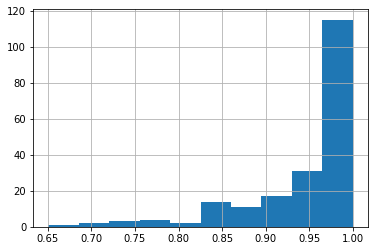

In [25]:
multi_labels.prim_scores.hist()

<AxesSubplot:>

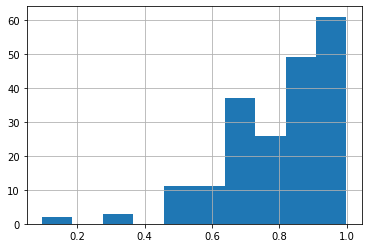

In [26]:
multi_labels.sec_scores.hist()

<AxesSubplot:>

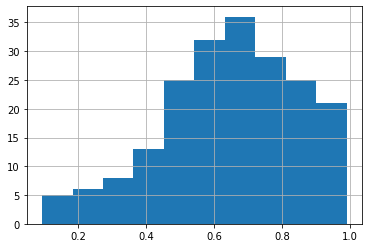

In [27]:
multi_labels.ter_scores.hist()

In [35]:
multi_labels[['prim_labels', 'sec_labels', 'ter_labels']].value_counts()

prim_labels               sec_labels              ter_labels              
Business and Finance      Careers                 Personal Finance            12
                          Real Estate             Personal Finance             9
                          Careers                 Technology & Computing       8
Music and Audio           Pop Culture             Business and Finance         8
Business and Finance      Personal Finance        Real Estate                  8
                                                                              ..
Pop Culture               Events and Attractions  Family and Relationships     1
                                                  Shopping                     1
Family and Relationships  Events and Attractions  Careers                      1
Business and Finance      Shopping                Technology & Computing       1
Healthy Living            Medical Health          Sports                       1
Length: 99, dtype: int64